In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/DIABETIC RETINOPATHY'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import cv2
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/DIABETIC RETINOPATHY/archive/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


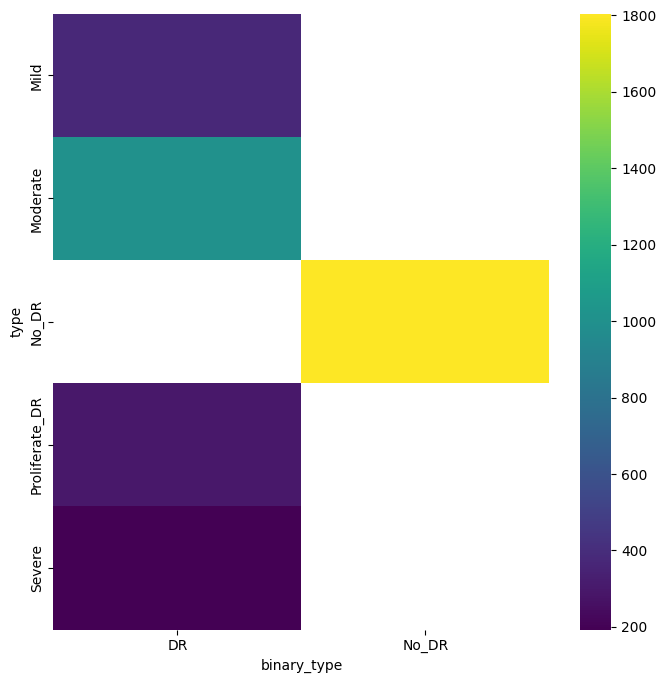

In [ ]:
# @title binary_type vs type

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['type'].value_counts()
    for x_label, grp in df.groupby('binary_type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('binary_type')
_ = plt.ylabel('type')

<Axes: ylabel='type'>

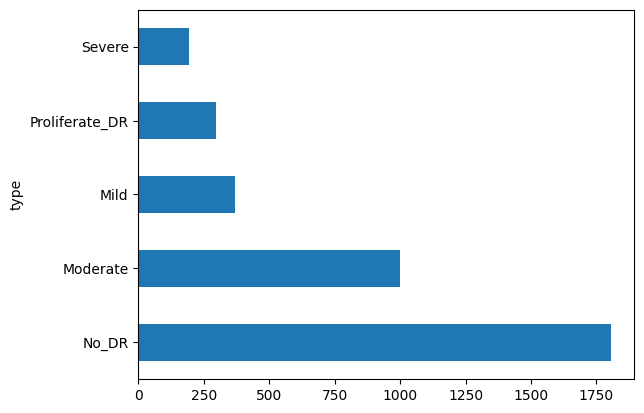

In [ ]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

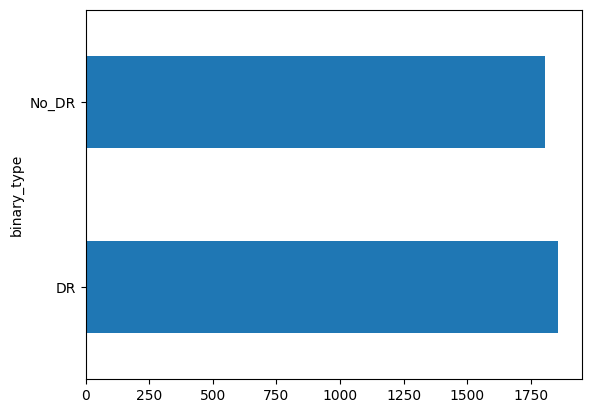

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [ ]:
# Copy images to respective working directory
src_dir = r'/content/drive/MyDrive/DIABETIC RETINOPATHY/archive/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [ ]:

# Setting up ImageDataGenerator for train/val/test
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir, target_size=(224, 224), class_mode='binary', shuffle=True
)
val_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=(224, 224), class_mode='binary', shuffle=True
)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=(224, 224), class_mode='binary', shuffle=False
)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [ ]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

# Corrected optimizer parameter
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - acc: 0.8076 - loss: 0.4857 - val_acc: 0.5073 - val_loss: 0.8595
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - acc: 0.9016 - loss: 0.2722 - val_acc: 0.5073 - val_loss: 1.2063
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - acc: 0.9220 - loss: 0.2297 - val_acc: 0.5073 - val_loss: 1.2068
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - acc: 0.9293 - loss: 0.2156 - val_acc: 0.5200 - val_loss: 0.9215
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - acc: 0.9259 - loss: 0.2103 - val_acc: 0.6545 - val_loss: 0.5325
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - acc: 0.9344 - loss: 0.1944 - val_acc: 0.9018 - val_loss: 0.2728
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - acc: 0.9359 - loss: 0.1793 - val_acc: 0.9182 - val_loss: 0.2042
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - acc: 0.9414 - loss: 0.1755 - val_acc: 0.9291 - val_loss: 0.1932
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - acc: 0.9452 - loss: 0.17

In [ ]:
# Save the model with a .keras extension (recommended)
model.save('64x3-CNN.keras')

# Alternatively, you can save with a .h5 extension
# model.save('64x3-CNN.h5')


In [ ]:
# Evaluate the model on the test data
loss, acc = model.evaluate(test_batches, verbose=1)

# Print the results
print("Loss: ", loss)
print("Accuracy: ", acc)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - acc: 0.9356 - loss: 0.1802
Loss:  0.14874689280986786
Accuracy:  0.9527272582054138


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - acc: 0.9356 - loss: 0.1802
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step


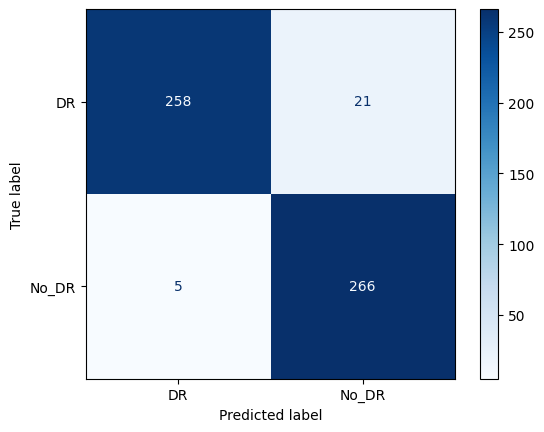

Loss:  0.14874689280986786
Accuracy:  0.9527272582054138


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Evaluate the model on the test data
loss, acc = model.evaluate(test_batches, verbose=1)

# Get predictions
test_batches.reset()  # Reset the test generator
predictions = model.predict(test_batches, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_batches.classes

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_batches.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print loss and accuracy
print("Loss: ", loss)
print("Accuracy: ", acc)


In [ ]:
from sklearn.metrics import f1_score

# Evaluate the model on the test data
loss, acc = model.evaluate(test_batches, verbose=1)

# Get predictions
test_batches.reset()  # Reset the test generator
predictions = model.predict(test_batches, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_batches.classes

# Calculate precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes, average='binary')
recall = recall_score(true_classes, predicted_classes, average='binary')
f1 = f1_score(true_classes, predicted_classes, average='binary')

# Print the results
print("Loss: ", loss)
print("Accuracy: ", acc)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - acc: 0.9356 - loss: 0.1802
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step
Loss:  0.14874689280986786
Accuracy:  0.9527272582054138
Precision: 0.9268
Recall: 0.9815
F1 Score: 0.9534


In [ ]:
def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    # Load the model using the correct extension
    new_model = tf.keras.models.load_model("64x3-CNN.keras")  # or "64x3-CNN.h5"
    predict = new_model.predict(np.array([image]))
    per = np.argmax(predict, axis=1)
    if per == 1:
        print('No DR')
    else:
        print('DR')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
DR


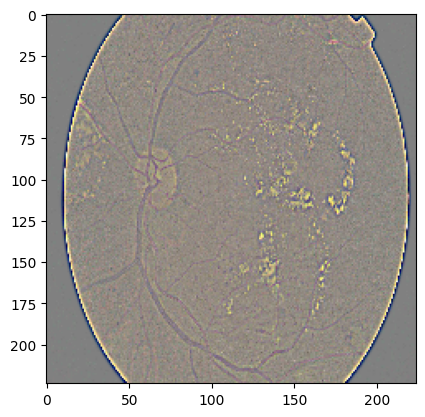

In [ ]:
predict_class('/content/drive/MyDrive/DIABETIC RETINOPATHY/archive/gaussian_filtered_images/gaussian_filtered_images/Severe/0dc8d25b3f69.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


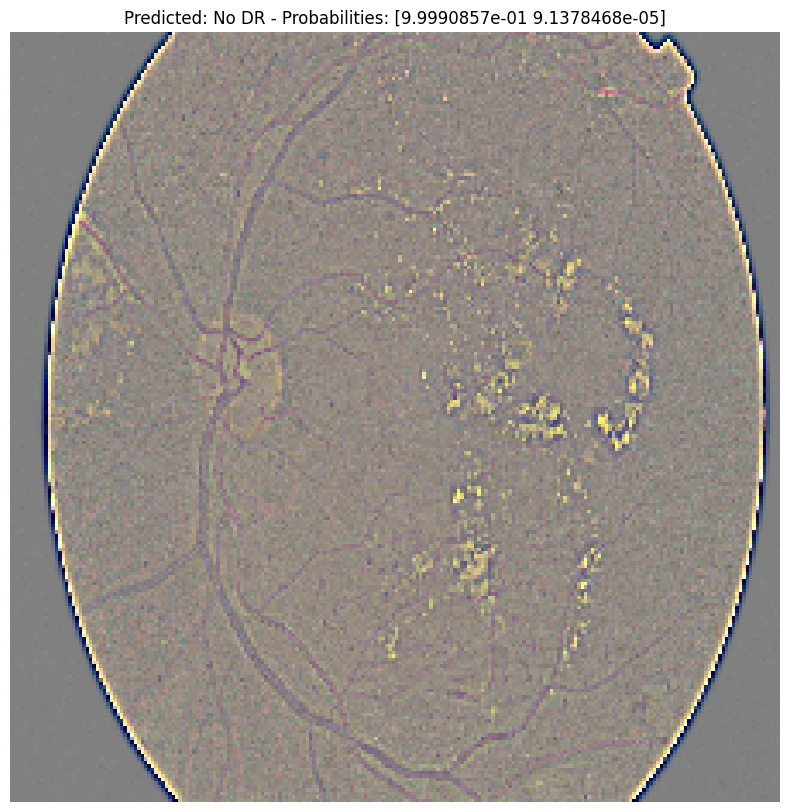

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('64x3-CNN.keras')  # Ensure this path is correct

# Define class labels
class_labels = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

# Function to make a prediction and get the predicted class
def predict_dr_type(model, image):
    # Preprocess the image
    image = np.array([image])  # Add batch dimension
    predictions = model.predict(image)  # Make a prediction with the image
    predicted_class_idx = np.argmax(predictions[0])  # Get the index of the highest score
    predicted_class = class_labels[predicted_class_idx]  # Map index to class label
    return predicted_class, predictions[0]  # Return predicted class and probabilities

# Function to display results
def show_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize the image

    # Get prediction
    predicted_class, probabilities = predict_dr_type(model, img_resized)

    # Plot original image and prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class} - Probabilities: {probabilities}')
    plt.show()

# Example usage
show_prediction('/content/drive/MyDrive/DIABETIC RETINOPATHY/archive/gaussian_filtered_images/gaussian_filtered_images/Severe/0dc8d25b3f69.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


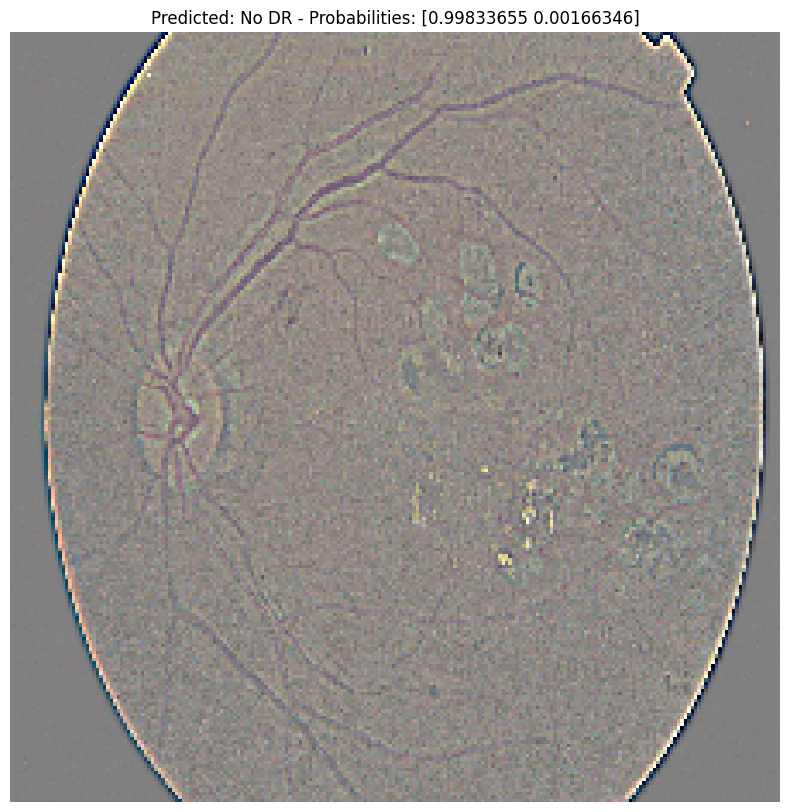

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('64x3-CNN.keras')  # Ensure this path is correct

# Define class labels
class_labels = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

# Function to make a prediction and get the predicted class
def predict_dr_type(model, image):
    # Preprocess the image
    image = np.array([image])  # Add batch dimension
    predictions = model.predict(image)  # Make a prediction with the image
    predicted_class_idx = np.argmax(predictions[0])  # Get the index of the highest score
    predicted_class = class_labels[predicted_class_idx]  # Map index to class label
    return predicted_class, predictions[0]  # Return predicted class and probabilities

# Function to display results
def show_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize the image

    # Get prediction
    predicted_class, probabilities = predict_dr_type(model, img_resized)

    # Plot original image and prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class} - Probabilities: {probabilities}')
    plt.show()

# Example usage
show_prediction('/content/drive/MyDrive/DIABETIC RETINOPATHY/archive/gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


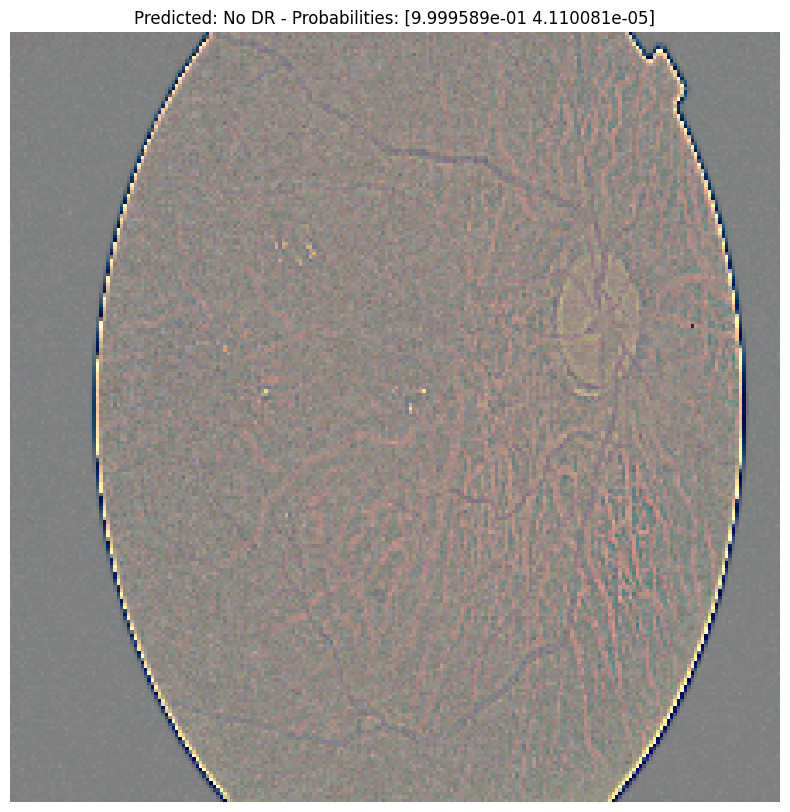

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('64x3-CNN.keras')  # Ensure this path is correct

# Define class labels
class_labels = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

# Function to make a prediction and get the predicted class
def predict_dr_type(model, image):
    # Preprocess the image
    image = np.array([image])  # Add batch dimension
    predictions = model.predict(image)  # Make a prediction with the image
    predicted_class_idx = np.argmax(predictions[0])  # Get the index of the highest score
    predicted_class = class_labels[predicted_class_idx]  # Map index to class label
    return predicted_class, predictions[0]  # Return predicted class and probabilities

# Function to display results
def show_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize the image

    # Get prediction
    predicted_class, probabilities = predict_dr_type(model, img_resized)

    # Plot original image and prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class} - Probabilities: {probabilities}')
    plt.show()

# Example usage
show_prediction('/content/drive/MyDrive/DIABETIC RETINOPATHY/archive/gaussian_filtered_images/gaussian_filtered_images/Moderate/012a242ac6ff.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


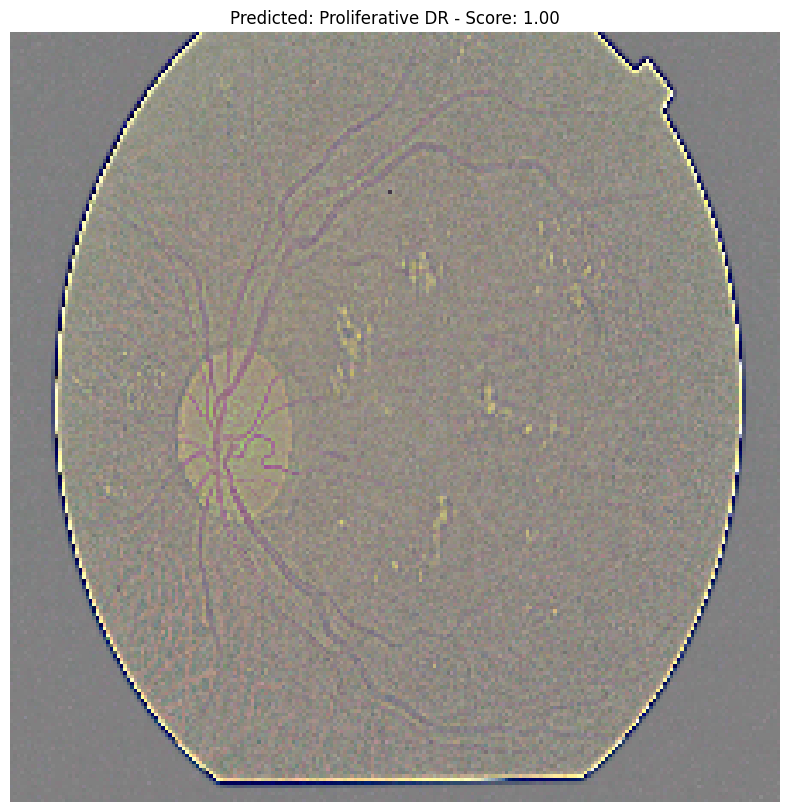

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('64x3-CNN.keras')  # Ensure this path is correct

# Function to make a prediction and classify DR type
def classify_dr_type(prediction):
    # Decision thresholds based on your model's output
    if prediction < 0.2:
        return "No DR"
    elif prediction < 0.4:
        return "Mild DR"
    elif prediction < 0.6:
        return "Moderate DR"
    elif prediction < 0.8:
        return "Severe DR"
    else:
        return "Proliferative DR"

# Function to make a prediction
def predict_dr(image):
    image = np.array([image])  # Add batch dimension
    prediction = model.predict(image)[0][0]  # Get the prediction score
    dr_type = classify_dr_type(prediction)  # Classify based on thresholds
    return dr_type, prediction  # Return the type and prediction score

# Function to display results
def show_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize the image

    # Get prediction
    dr_type, prediction = predict_dr(img_resized)

    # Plot original image and prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {dr_type} - Score: {prediction:.2f}')
    plt.show()

# Example usage
show_prediction('/content/drive/MyDrive/DIABETIC RETINOPATHY/archive/gaussian_filtered_images/gaussian_filtered_images/Moderate/03fd50da928d.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


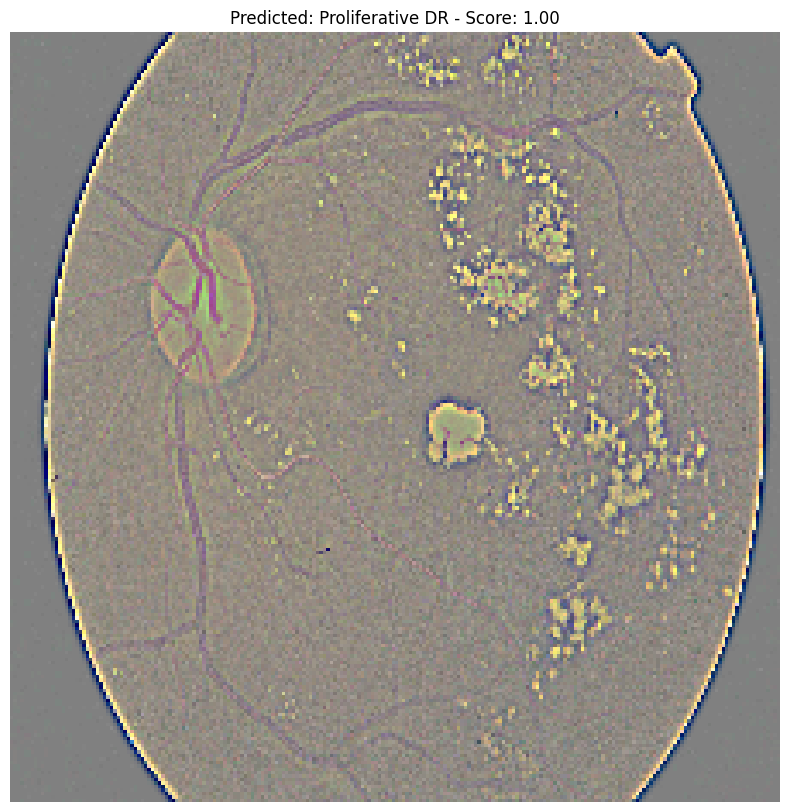

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('64x3-CNN.keras')  # Ensure this path is correct

# Function to make a prediction and classify DR type
def classify_dr_type(prediction):
    # Decision thresholds based on your model's output
    if prediction < 0.2:
        return "No DR"
    elif prediction < 0.4:
        return "Mild DR"
    elif prediction < 0.6:
        return "Moderate DR"
    elif prediction < 0.8:
        return "Severe DR"
    else:
        return "Proliferative DR"

# Function to make a prediction
def predict_dr(image):
    image = np.array([image])  # Add batch dimension
    prediction = model.predict(image)[0][0]  # Get the prediction score
    dr_type = classify_dr_type(prediction)  # Classify based on thresholds
    return dr_type, prediction  # Return the type and prediction score

# Function to display results
def show_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize the image

    # Get prediction
    dr_type, prediction = predict_dr(img_resized)

    # Plot original image and prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {dr_type} - Score: {prediction:.2f}')
    plt.show()

# Example usage
show_prediction('//content/drive/MyDrive/DIABETIC RETINOPATHY/archive/gaussian_filtered_images/gaussian_filtered_images/Severe/0104b032c141.png')
